Processing Singapore...
Road network loading time:  15.344872951507568


Iterations..: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [4:39:08<00:00, 83.74s/it]


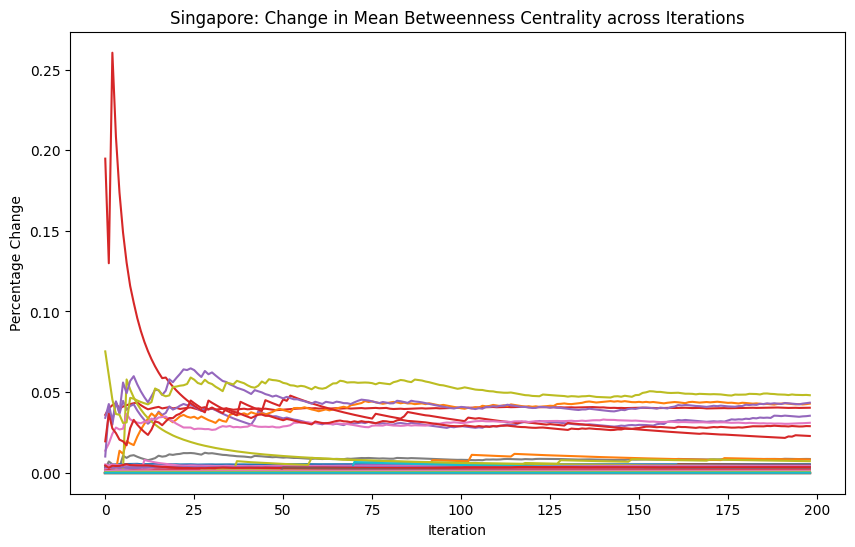

len(overall_mean_bc_per_node), len(G.nodes()) : 249222 249222
Processing Zurich...
Road network loading time:  38.71138286590576


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [20:19<00:00,  6.10s/it]


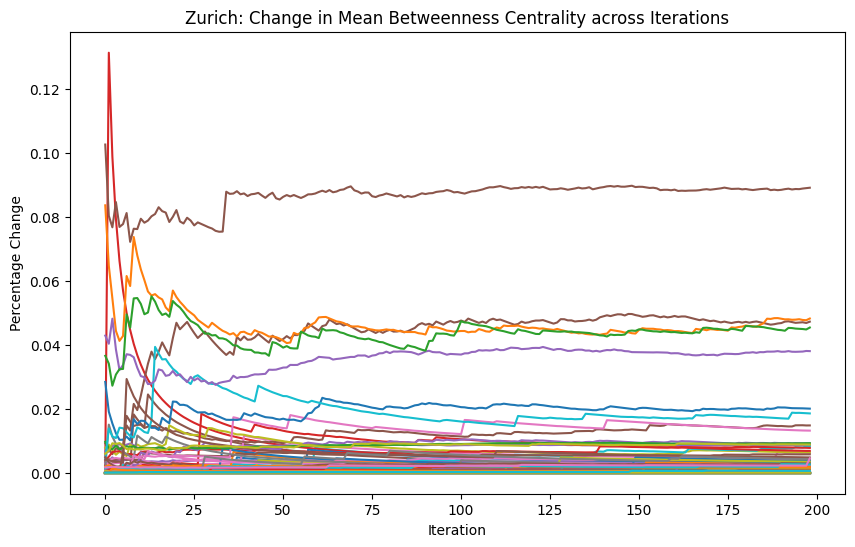

len(overall_mean_bc_per_node), len(G.nodes()) : 430737 430737
Processing Mumbai...
Road network loading time:  15.938982248306274


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [05:37<00:00,  1.69s/it]


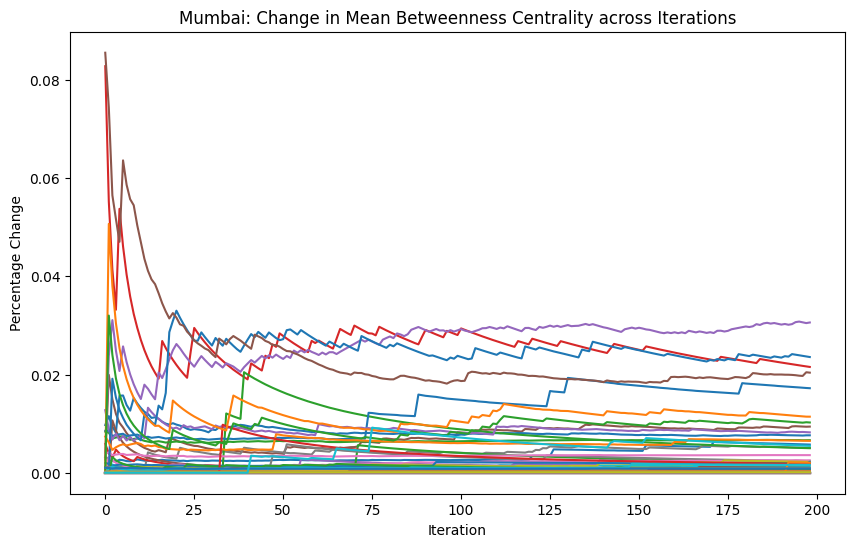

len(overall_mean_bc_per_node), len(G.nodes()) : 163881 163881
Processing Auckland...
Road network loading time:  19.98446273803711


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [12:06<00:00,  3.63s/it]


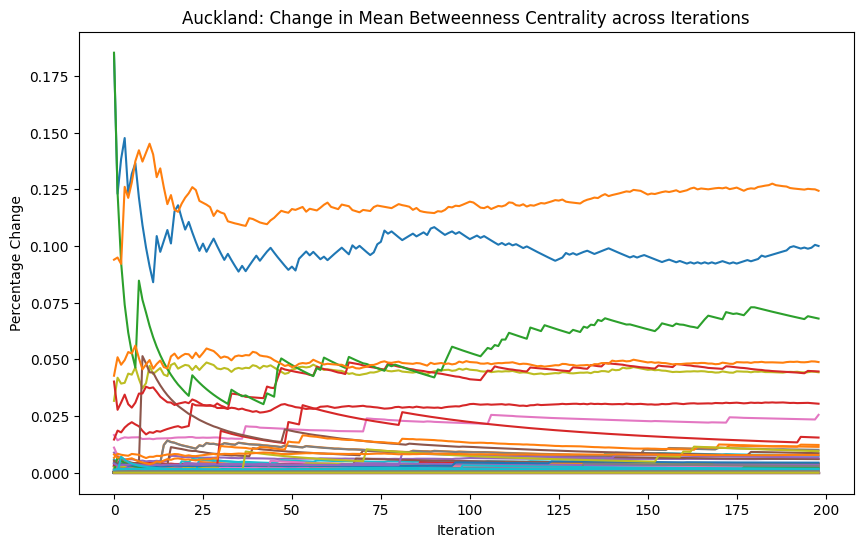

len(overall_mean_bc_per_node), len(G.nodes()) : 244224 244224
Processing Istanbul...
Road network loading time:  31.423806190490723


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [15:23<00:00,  4.62s/it]


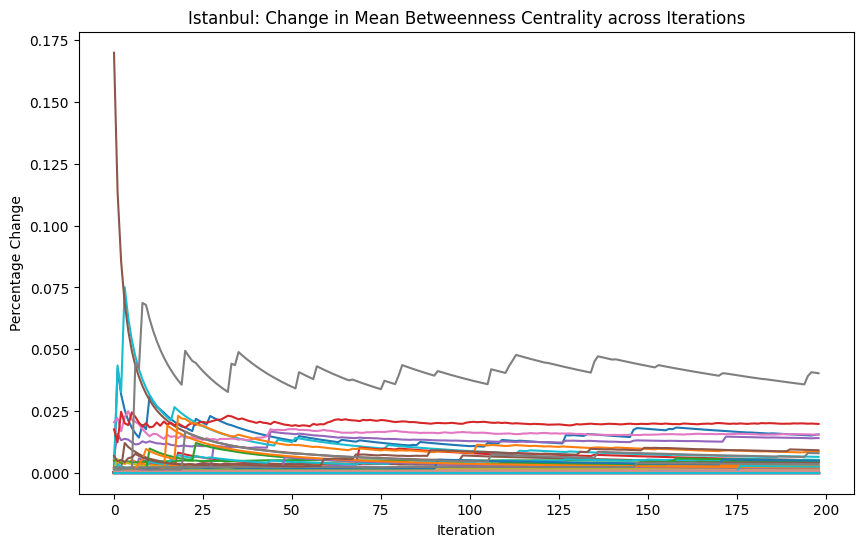

len(overall_mean_bc_per_node), len(G.nodes()) : 338587 338587
Processing MexicoCity...
Road network loading time:  45.959409952163696


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [24:14<00:00,  7.27s/it]


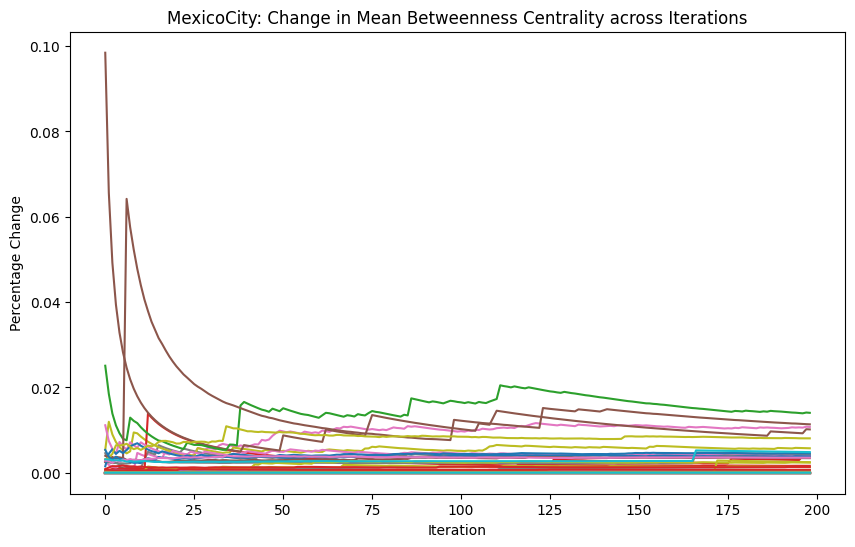

len(overall_mean_bc_per_node), len(G.nodes()) : 529743 529743
Processing Bogota...
Road network loading time:  31.042595148086548


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [13:54<00:00,  4.17s/it]


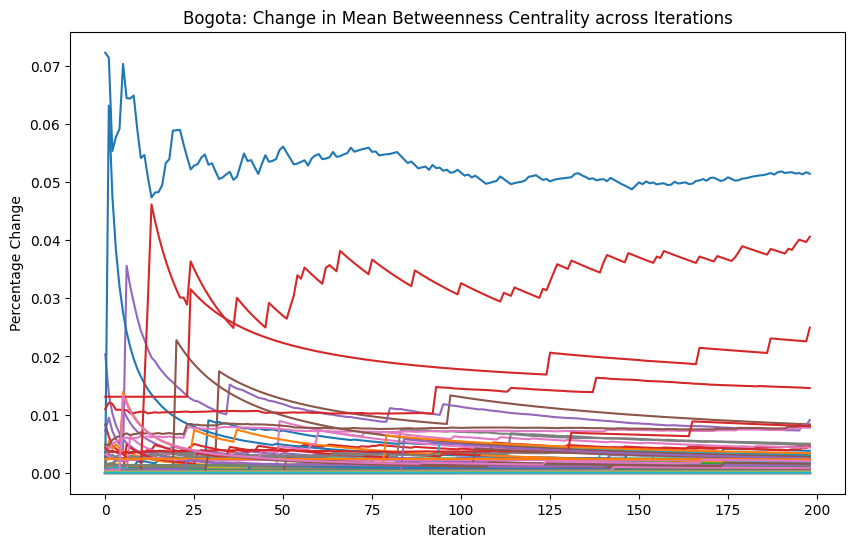

len(overall_mean_bc_per_node), len(G.nodes()) : 312671 312671
Processing NewYorkCity...
Road network loading time:  41.696511030197144


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [25:57<00:00,  7.79s/it]


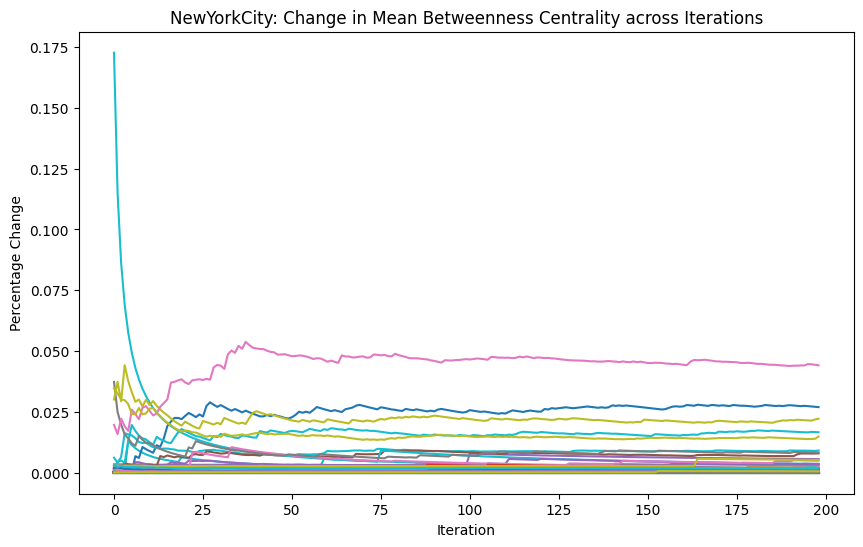

len(overall_mean_bc_per_node), len(G.nodes()) : 542875 542875
Processing Capetown...
Road network loading time:  34.42037296295166


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [16:00<00:00,  4.80s/it]


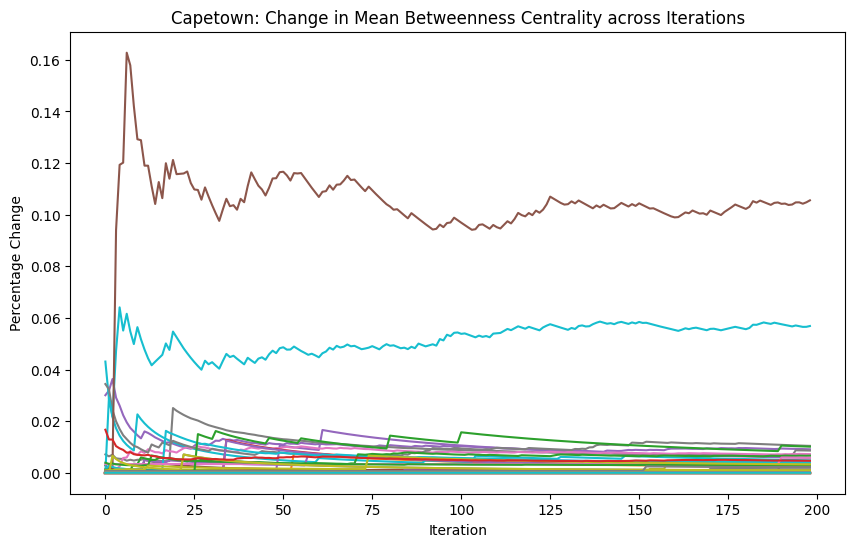

len(overall_mean_bc_per_node), len(G.nodes()) : 379691 379691
Processing London...
Road network loading time:  82.9367561340332


Iterations..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [39:38<00:00, 11.89s/it]


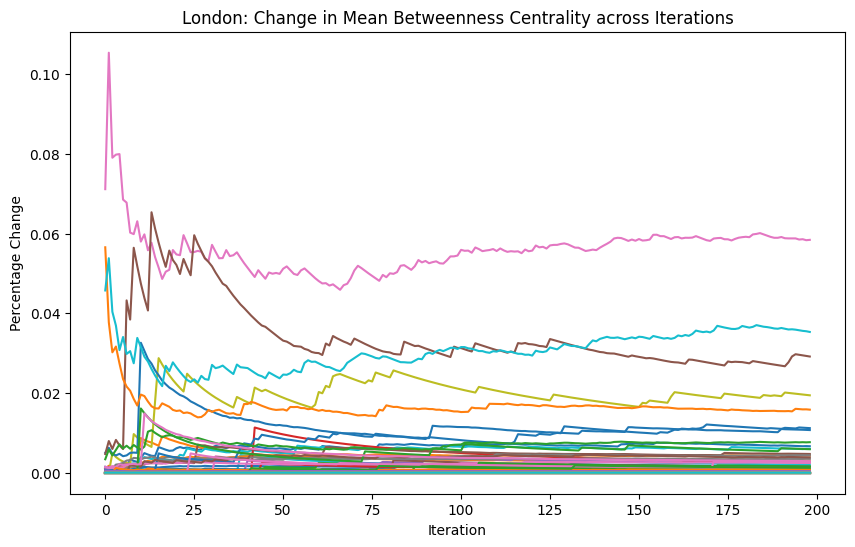

len(overall_mean_bc_per_node), len(G.nodes()) : 783310 783310
Finished processing all cities.


In [3]:
import copy
import os
import pickle
import time
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys

sys.path.append("../..")
import config
from urbanscales.io.road_network import RoadNetwork
from urbanscales.preprocessing.prep_network import Scale
from urbanscales.preprocessing.prep_speed import ScaleJF
from urbanscales.preprocessing.tile import Tile
import pandas as pd
from tqdm import tqdm

from smartprint import smartprint as sprint
from slugify import slugify

import networkx as nx
import matplotlib.pyplot as plt
import random
import tqdm
import pickle

rn_city_wise_tz_code = {
    "Singapore": "Asia/Singapore",
    "Zurich": "Europe/Zurich",
    "Mumbai": "Asia/Kolkata",
    "Auckland": "Pacific/Auckland",
    "Istanbul": "Europe/Istanbul",
    "MexicoCity": "America/Mexico_City",
    "Bogota": "America/Bogota",
    "NewYorkCity": "America/New_York",
    "Capetown": "Africa/Johannesburg",
    "London": "Europe/London"
}

K = 2
iterations = 200
num_random_nodes = 200

for city, _ in rn_city_wise_tz_code.items():
    print(f"Processing {city}...")

    # Assuming the Scale.get_object method works for every city
    G = RoadNetwork.get_object(city).G_osm

    initial_bc = nx.betweenness_centrality(G, k=K)
    all_nodes = list(initial_bc.keys())
    random_nodes = random.sample(list(initial_bc.keys()), num_random_nodes)
    

    # Dictionary to store the mean betweenness centrality values for each node up to each iteration
    mean_values_per_node = {node: [] for node in all_nodes}

    for i in tqdm.tqdm(range(iterations), desc="Iterations.."):
        bc = nx.betweenness_centrality(G, k=K)
        for node in all_nodes:
            if i == 0:
                current_mean = bc[node]
            else:
                current_mean = (mean_values_per_node[node][-1] * i + bc[node]) / (i + 1)
            mean_values_per_node[node].append(current_mean)

    # Compute the percentage change in mean values across iterations for each node
    percentage_changes_per_node = {node: [] for node in all_nodes}
    
    plt.figure(figsize=(10, 6))
    for node in random_nodes:
        mean_values = mean_values_per_node[node]
        percentage_changes = []
        for i in range(1, len(mean_values)):
            # if mean_values[i-1] != 0:
            #     percentage_change = ((mean_values[i] - mean_values[i-1]) / mean_values[i-1]) * 100
            # else:
            #     percentage_change = np.nan

             
            percentage_changes.append(mean_values[i])
        percentage_changes_per_node[node] = mean_values[i]

        # Plot the percentage change in mean values for the current node
 
        plt.plot(percentage_changes) # , label=f'Node {node}', marker='o')

    # plt.ylim(-100, 100)
    # plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('Percentage Change')
    plt.title( city + ': Change in Mean Betweenness Centrality across Iterations')        
    plt.show()

    # Save mean betweenness centrality results for the city to a pickle file
    overall_mean_bc_per_node = {node: sum(values) / len(values) for node, values in mean_values_per_node.items()}
    sprint(len(overall_mean_bc_per_node), len(G.nodes()))
    with open(os.path.join(config.BASE_FOLDER, config.network_folder, \
                               city + "_mean_betweenness_centrality.pkl"), "wb") as f:
        pickle.dump(overall_mean_bc_per_node, f)

print("Finished processing all cities.")

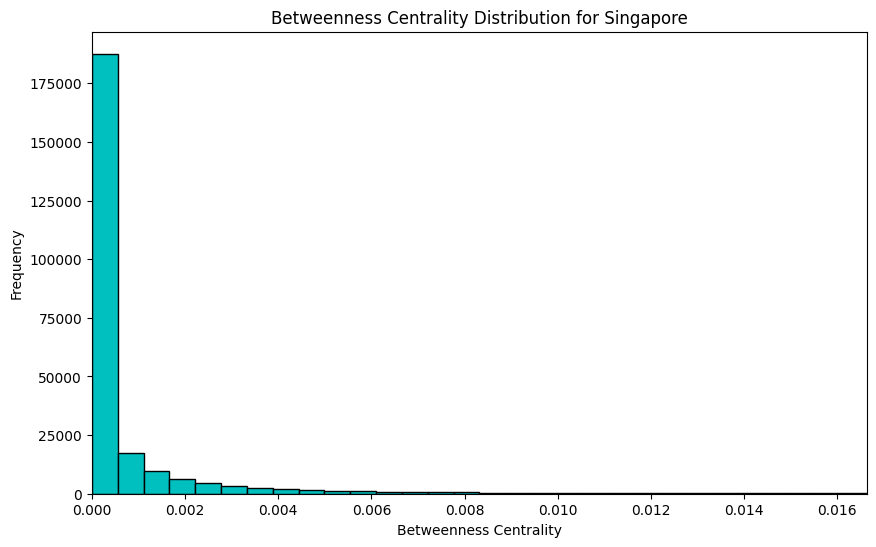

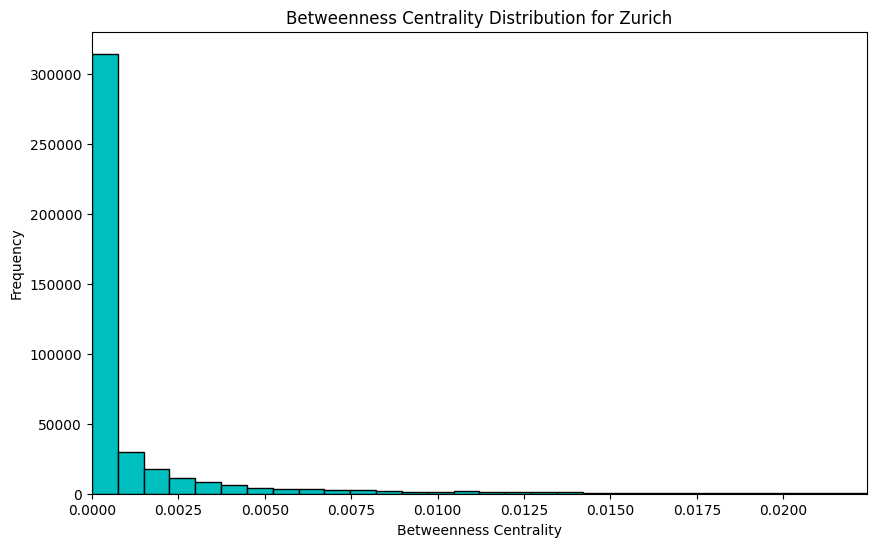

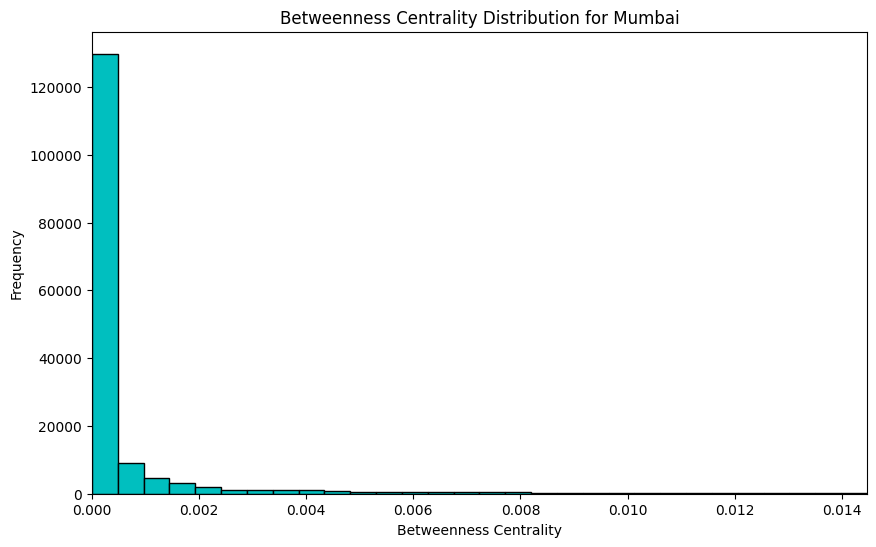

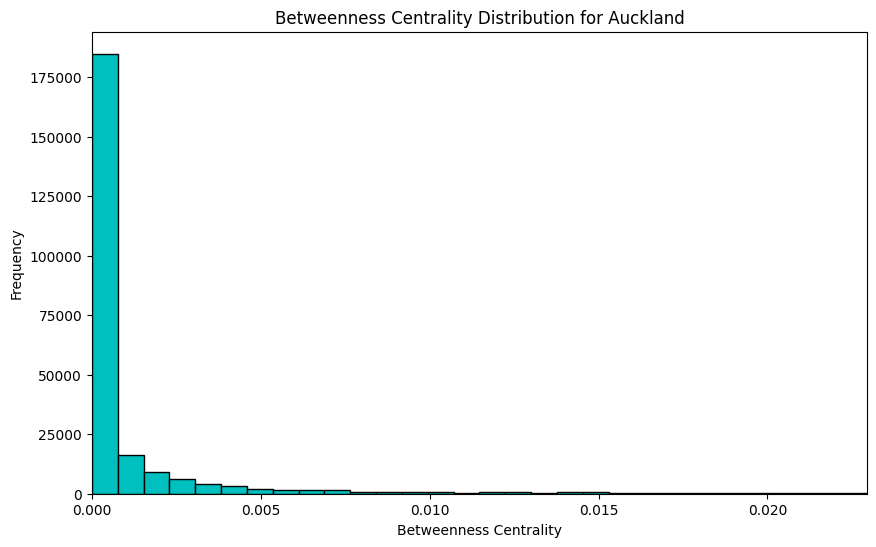

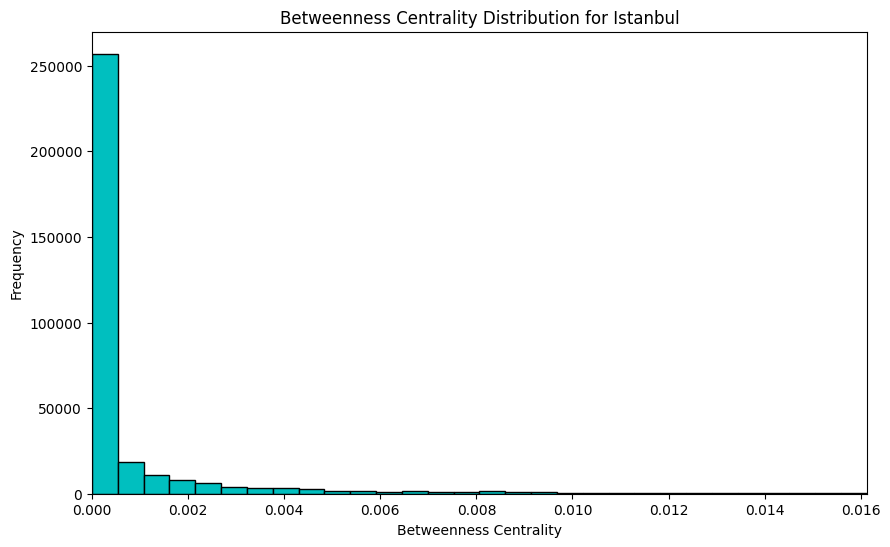

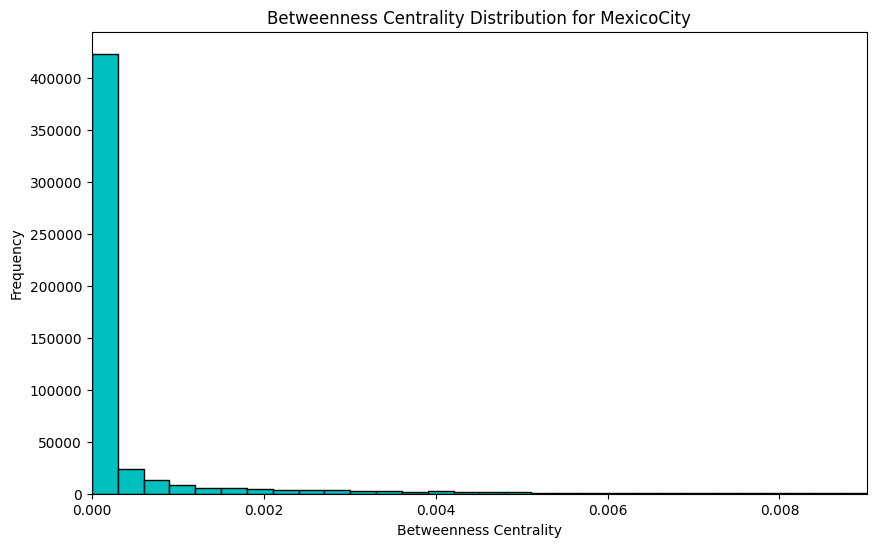

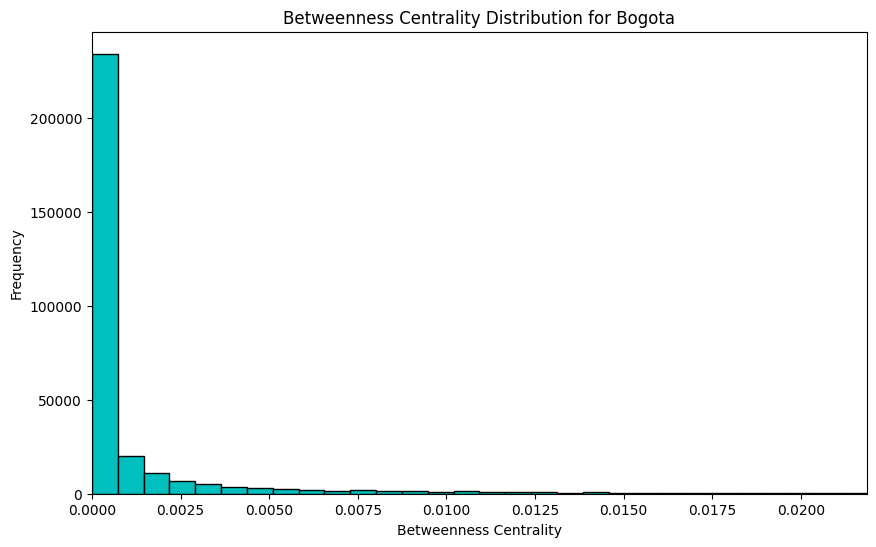

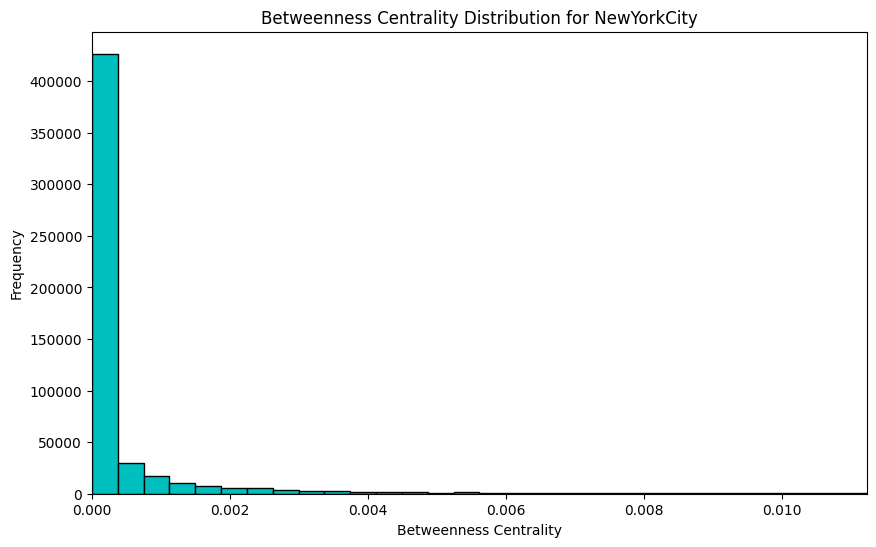

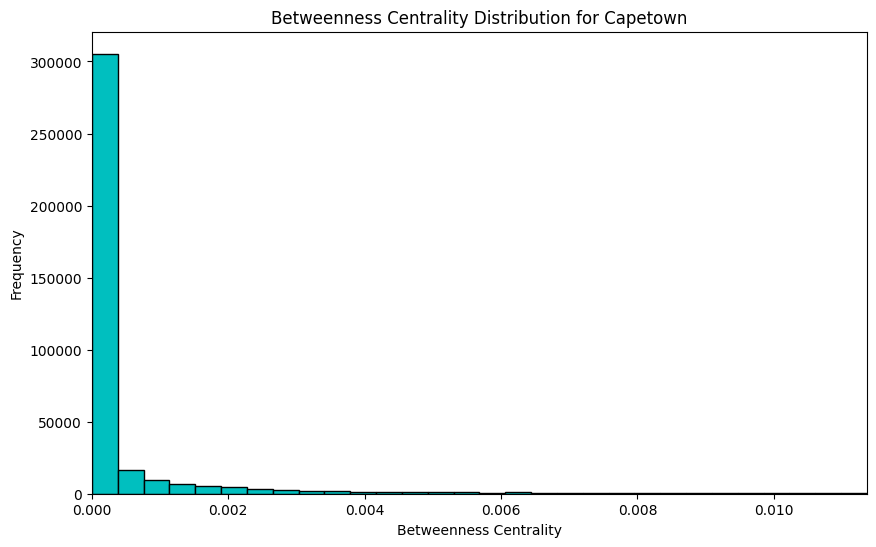

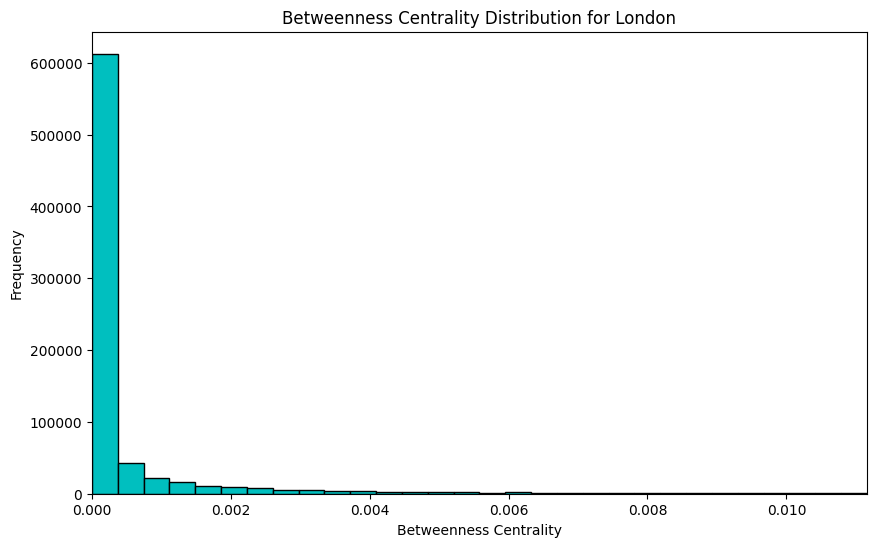

In [8]:
import os
import pickle
import matplotlib.pyplot as plt

def plot_histogram(city, bc_values):
    plt.figure(figsize=(10, 6))
    
    # Calculate 10 times the mean
    cutoff = 10 * np.mean(bc_values)
    
    # Plot the histogram with the adjusted range
    plt.hist([value for value in bc_values if value <= cutoff], bins=30, color='c', edgecolor='black', range=(0, cutoff))
    
    plt.title(f'Betweenness Centrality Distribution for {city}')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')
    plt.xlim(0, cutoff)  # Setting the x-axis limit
    plt.show()

for city in rn_city_wise_tz_code.keys():
    pickle_file_path = os.path.join(config.BASE_FOLDER, config.network_folder, city + "_300_mean_betweenness_centrality.pkl")
    
    # Load the betweenness centrality values for the city from the pickle file
    with open(pickle_file_path, "rb") as f:
        bc_values = pickle.load(f)
    
    plot_histogram(city, list(bc_values.values()))
